# Decoder only LLMs: From Input to EOS Token

### Tokenization of the Input
The LLM receives a text as its input. This text is then converted to a sequence of tokens using a tokenizer. As a rule of thumb it can be said that one token corresponds to about 4 characters of text for common english text.

When working with code however, the tokens are then returned as a numerical representation by the tokenizer. The mapping from the textual representation into the numerical representation is based on a vocabulary which is built during the training process of the model. This vocabulary contains a finite amount of tokens and corresponding IDs. The tokens can be words, part of words and special tokens such as \[PAD\] for padding or \[EOS\] for End-of-Sequence.

In [158]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_text = "Michael Jordan plays"

# IDs to reference the corresponding embeddings in the vocabulary
input_ids = tokenizer.encode(input_text, return_tensors="pt")

tokens = tokenizer.tokenize(input_text)

print("Input IDs:", input_ids)
print("Tokens:", tokens)

Input IDs: tensor([[13256,  8078,  5341]])
Tokens: ['Michael', 'ĠJordan', 'Ġplays']


/Users/i551965/Library/Caches/pypoetry/virtualenvs/deeplearning_bs-Vefx44GI-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The Ġ character is a prefix indicates a so called **Byte Pair Encoding (BPE)**. It is supposed to show that the token it preceeds is the begining of a new word following a space. This is for example why the uppercase `The` is prefixed with the Ġ, but the lowercase `the` is not.

### Embedding the tokens
The respective embeddings for each token are then retrieved using an embedding matrix $E$ which is learned during training. $E$ has the dimensionality $N\times D$ where $N$ is the total amount of tokens and $D$ is the amount of dimensions each embedding has. Finally, each embedding is enriched by a positional encoding that gives information about which position this embedding has in the input sequence.

In [160]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
embedding_vocabulary = model.transformer.wte.weight

embeddings = []
for id in input_ids[0]:
    embeddings.append(embedding_vocabulary[id])

print(len(embeddings))

3


### Self-Attention

50257
3


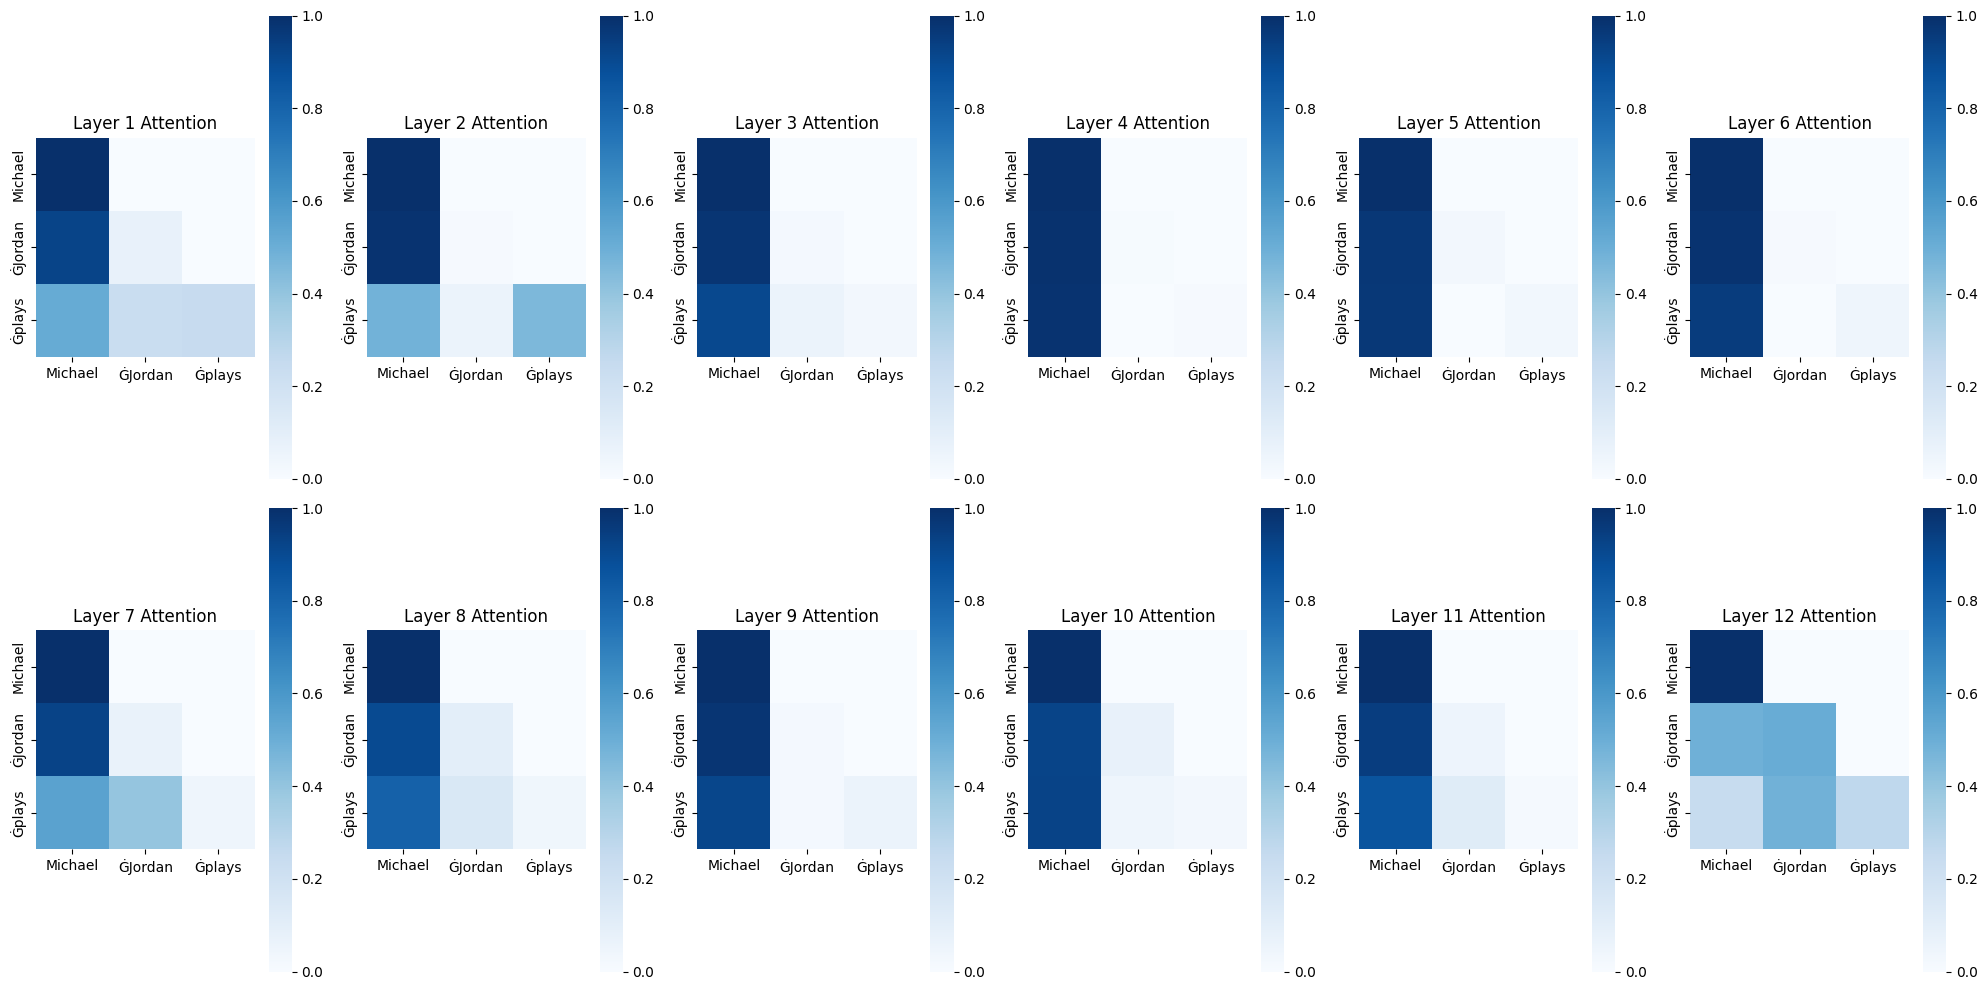

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    outputs = model(input_ids)

# Generate output from logits
# Get the last token's logits (which corresponds to the end of the input sequence)
logits = outputs.logits
print(len(logits[0][0]))
last_token_logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size)

# Step 4: Extract attention weights (outputs.attentions is a tuple with one element for each layer)
attentions = outputs.attentions  # Shape: (num_layers, batch_size, num_heads, seq_length, seq_length)

# Step 5: Visualize attention matrix for each layer and each head
num_layers = len(attentions)
seq_len = input_ids.shape[1]
print(seq_len)

plt.figure(figsize=(20, 10))

for layer in range(num_layers):
    # Get the attention for the first head in this layer (can loop over all heads if you want)
    attention_matrix = attentions[layer][0, 0].cpu().numpy()  # Shape: (seq_length, seq_length)
    
    # Step 6: Plot the attention matrix
    plt.subplot(2, num_layers // 2, layer + 1)
    sns.heatmap(attention_matrix, cmap="Blues", annot=False, square=True, cbar=True, xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]))
    plt.title(f"Layer {layer + 1} Attention")

plt.tight_layout()
plt.show()

### Feedforward Neural Net

In [162]:
hidden_states = outputs.hidden_states  # Shape: (num_layers + 1, batch_size, seq_length, hidden_size)
num_layers = len(hidden_states) - 1  # Subtract 1 because the first hidden state is the input embedding

for layer in range(1, num_layers + 1):
    # Get hidden state for the current layer and the next layer (before and after feedforward)
    input_to_feedforward = hidden_states[layer - 1]  # Input to the feedforward (before the layer's transformation)
    output_from_feedforward = hidden_states[layer]   # Output from the feedforward (after the layer's transformation)
    
    # Print input and output shape for the feedforward network
    print(f"Layer {layer}:")
    print(f"Input to Feedforward (Layer {layer - 1} output): {input_to_feedforward.shape}")  # Shape: (batch_size, seq_length, hidden_size)
    print(f"Output from Feedforward (Layer {layer} output): {output_from_feedforward.shape}")  # Shape: (batch_size, seq_length, hidden_size)")
    
    # Optionally print the actual values (can print specific token values if input is large)
    print(f"Input to Feedforward (first token): {input_to_feedforward[0, 0, :5]}")  # Print first 5 elements of first token
    print(f"Output from Feedforward (first token): {output_from_feedforward[0, 0, :5]}")  # Print first 5 elements of first token
    print("\n")


Layer 1:
Input to Feedforward (Layer 0 output): torch.Size([1, 3, 768])
Output from Feedforward (Layer 1 output): torch.Size([1, 3, 768])
Input to Feedforward (first token): tensor([-0.0833, -0.3048,  0.1871, -0.0248, -0.0583])
Output from Feedforward (first token): tensor([-1.1134, -1.2075,  0.1579,  0.2430, -0.8501])


Layer 2:
Input to Feedforward (Layer 1 output): torch.Size([1, 3, 768])
Output from Feedforward (Layer 2 output): torch.Size([1, 3, 768])
Input to Feedforward (first token): tensor([-1.1134, -1.2075,  0.1579,  0.2430, -0.8501])
Output from Feedforward (first token): tensor([-1.1750, -1.5272,  0.9332,  0.5939, -0.1987])


Layer 3:
Input to Feedforward (Layer 2 output): torch.Size([1, 3, 768])
Output from Feedforward (Layer 3 output): torch.Size([1, 3, 768])
Input to Feedforward (first token): tensor([-1.1750, -1.5272,  0.9332,  0.5939, -0.1987])
Output from Feedforward (first token): tensor([-0.9776, -1.7069,  0.7627,  0.7636,  0.1439])


Layer 4:
Input to Feedforward (

### Generating the next token
After the last token of the input sequence has been enriched with contextual information from all previous tokens using the self-attention mechanism, it is now used to make a prediction for the next token using a linear layer. Mathematically, this can be denoted as:
$$P(\text{next token}|X)=softmax(X_tW_{vocab})$$
- $X$ being the input sequence
- $softmax$ converts a vector of real numbers into a probability distribution
- $X_t$ being the last element in the input sequence
- $W_{vocab}$ being a weight matrix learned during training

This formula results in a probability distribution over all possible tokens in the vocabulary, so a vector of size $N$. Picking the token that will be chosen next can be done in a variety of ways including: 
- **Greedy decoding**: Always picking the token with the highest probability
- **Sampling**: Sampling from the resulting probability distribution according to the respective probabilities of each token
The chosen token is then appended to the input sequence and the process of embedding, self-attention and generating the next token is repeated. This happens until a stopping condition is reached.

In [163]:
import torch.nn.functional as F

logits = outputs.logits
probabilities = F.softmax(logits, dim=-1)

# Find the ten highest probabilities and their corresponding token IDs
top_k = 10
top_probabilities, top_indices = torch.topk(probabilities[0][-1], top_k)

# Print the ten highest probabilities and their corresponding token IDs
for i in range(top_k):
    token_id = top_indices[i].item()
    probability = top_probabilities[i].item()
    token = tokenizer.decode([token_id])
    print(f"Token ID: {token_id}, Token: {token}, Probability: {probability:.4f}")


# Specify the decoding method: "greedy" for greedy decoding, "sample" for sampling
decoding_method = "sample"

if decoding_method == "greedy":
    next_token_prediction_id = torch.argmax(probabilities[0][-1])
    next_token_prediction = tokenizer.decode([next_token_prediction_id])
elif decoding_method == "sample":
    next_token_prediction_id = torch.multinomial(probabilities[0][-1], num_samples=1).item()
    next_token_prediction = tokenizer.decode([next_token_prediction_id])
else:
    print(f"Invalid decoding method {decoding_method}.")

print(f"The id of the next predicted token is {next_token_prediction_id} and the corresponding token is {next_token_prediction}")

Token ID: 262, Token:  the, Probability: 0.1155
Token ID: 257, Token:  a, Probability: 0.0913
Token ID: 287, Token:  in, Probability: 0.0635
Token ID: 351, Token:  with, Probability: 0.0369
Token ID: 13, Token: ., Probability: 0.0344
Token ID: 329, Token:  for, Probability: 0.0314
Token ID: 465, Token:  his, Probability: 0.0310
Token ID: 319, Token:  on, Probability: 0.0262
Token ID: 11, Token: ,, Probability: 0.0197
Token ID: 281, Token:  an, Probability: 0.0125
The id of the next predicted token is 257 and the corresponding token is  a


### Stopping Condition
The model stops predicting when a certain token, called the **End-ofSequence (EOS)** token is predicted. In GPT, this is the token with ID 50256.

In [164]:
import torch
import torch.nn.functional as F

# Assume 'model' is your GPT model and 'tokenizer' is the tokenizer used
# Start with an initial input (prompt)
input_text = "The man worked as the cardiologist"
input_ids = tokenizer.encode(input_text, return_tensors='pt')  # Convert to tensor

# Specify the device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
input_ids = input_ids.to(device)

# Initialize an empty list to store generated tokens
generated_tokens = []

# Specify the maximum number of tokens to generate to avoid infinite loops
max_length = 50

# Generate tokens until EOS or max_length is reached
for i in range(max_length):
    print(i)
    # Get the model's output
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
    
    # Get the probabilities and sample from the distribution
    probabilities = F.softmax(logits[:, -1, :], dim=-1)
    
    # Sample the next token using multinomial sampling
    next_token_id = torch.multinomial(probabilities[0], num_samples=1).item()
    
    # Append the generated token ID to the list
    generated_tokens.append(next_token_id)
    
    # Print the generated token and its ID
    token = tokenizer.decode([next_token_id])
    print(f"Generated Token: {token}, Token ID: {next_token_id}")

    # Break the loop if the generated token is the EOS token
    if next_token_id == tokenizer.eos_token_id:
        break
    
    # Update the input_ids to include the new token
    input_ids = torch.cat((input_ids, torch.tensor([[next_token_id]], device=device)), dim=1)

# Decode the generated tokens to a string
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

# Print the generated output
print("Generated text:", generated_text)

0
Generated Token:  of, Token ID: 286
1
Generated Token:  St, Token ID: 520
2
Generated Token: ., Token ID: 13
3
Generated Token:  Len, Token ID: 12592
4
Generated Token: oir, Token ID: 10840
5
Generated Token:  Park, Token ID: 3250
6
Generated Token: ,, Token ID: 11
7
Generated Token:  an, Token ID: 281
8
Generated Token:  hour, Token ID: 1711
9
Generated Token:  from, Token ID: 422
10
Generated Token:  U, Token ID: 471
11
Generated Token: ., Token ID: 13
12
Generated Token: N, Token ID: 45
13
Generated Token: ., Token ID: 13
14
Generated Token:  headquarters, Token ID: 10043
15
Generated Token:  in, Token ID: 287
16
Generated Token:  the, Token ID: 262
17
Generated Token:  city, Token ID: 1748
18
Generated Token: ,, Token ID: 11
19
Generated Token:  and, Token ID: 290
20
Generated Token:  died, Token ID: 3724
21
Generated Token:  at, Token ID: 379
22
Generated Token:  his, Token ID: 465
23
Generated Token:  home, Token ID: 1363
24
Generated Token:  on, Token ID: 319
25
Generated Toke